# Prácticas ESAC: Strömgren Radius Hu18

1. HSC -y - NB964 [mag] - EW [Å] Relation
2. Extracted data from Hu18
3. Filter in redshift
4. Strömgen Radius

   Appendix A: Saving data

In [11]:
# Paquetes
from astropy.table import Table, QTable, unique
from astropy.io import ascii
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import smplotlib
from uncertainties import ufloat, unumpy
import uncertainties.unumpy as unp
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import sys

# Definimos Mpc en unidades propias comóviles
pMpc = u.def_unit('pMpc')
cMpc = u.def_unit('cMpc')

## 1. HSC -y - NB964 [mag] - EW [Å] Relation

En esta sección, vamos a ajustar la relación HSC -y - NB964 [mag] - EW [Å] a partir de la figura Extended Data Fig.1 del paper 9 (Wida Hu, et al. (2021), Nature Astronomy). Este ajuste es necesario para poder estimar la anchura equivalente $EW_{obs}$ observada, necesaria para los cálculos posteriores. Nótese que para la relación de Sobral se utiliza $EW$ en el rest frame, por lo que tendremos que pasar de osbservada a emitida como

$$
\begin{equation}
    EW_{rest-frame} = \frac{EW_{obs}}{1+z} \equiv EW .
\end{equation}
$$

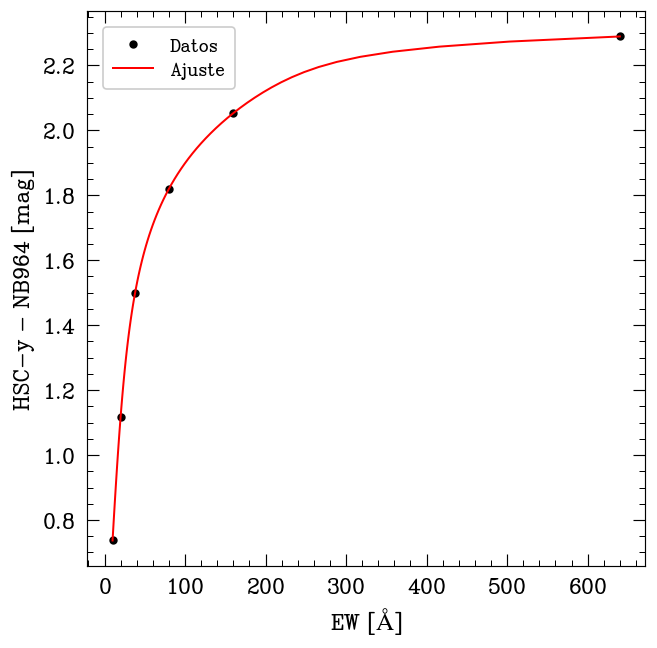

In [2]:
# Datos proporcionados
EW = [10, 20, 38, 80, 160, 640]
HSC_NB964 = [0.737, 1.118, 1.5, 1.82, 2.053, 2.289]

# Ajuste polinómico de n orden
n = 100
coefficients = np.polyfit(HSC_NB964, EW, n)
poly_fit = np.poly1d(coefficients)

# Visualización del ajuste y puntos encontrados
HSC_NB964_fit = np.linspace(min(HSC_NB964), max(HSC_NB964), 100)
EW_fit = poly_fit(HSC_NB964_fit)

plt.plot(EW, HSC_NB964, '.', label = 'Datos')
plt.plot(EW_fit, HSC_NB964_fit, label='Ajuste', color='red')
plt.legend(fontsize = 12, frameon = True)
plt.xlabel(f'EW [$Å$]')
plt.ylabel('HSC-y - NB964 [mag]')
plt.show()

## 2. Extracted data from Hu18

A continuación, importamos la _Supplementary Table 1_ del paper 9 (Weida Hu et al. (2018)).

In [3]:
# Creamos la tabla de datos de Hu18
data_Hu18 = {
    'ID': ['LAE-1', 'LAE-2', 'LAE-3', 'LAE-4', 'LAE-5', 'LAE-6', 'LAE-7', 'LAE-9', 'LAE-10', 'LAE-11', 'LAE-13', 'LAE-15', 'LAE-16', 'LAE-17', 'LAE-18', 'LAE-19','LAE-8', 'LAE-12', 'LAE-14', 'LAE-20', 'LAE-21'],
    'RA': ['10:02:06.0', '10:01:53.5', '10:03:10.5', '10:03:32.7', '10:03:30.7', '10:03:28.0', '10:03:05.2', '10:03:16.0', '10:02:42.3', '10:02:39.4', '10:02:33.5', '10:02:23.4', '10:02:32.9', '10:03:33.5', '10:03:37.3', '10:03:39.3','10:02:09.0', '10:03:00.1', '10:02:08.3', '10:02:47.1', '10:03:15.6'],
    'DEC': ['+02:06:46.3', '+02:04:59.8', '+02:12:30.8', '+02:09:25.1', '+02:14:08.5', '+02:08:51.3', '+02:09:14.7', '+02:15:42.3', '+02:06:55.2', '+02:07:12.1', '+02:07:09.5', '+02:05:04.8', '+02:05:52.8', '+02:07:19.8', '+02:07:36.7', '+02:07:47.2','+02:04:11.0', '+02:14:49.5', '+02:06:59.6', '+02:10:40.1', '+02:18:11.3'],
    'logLLya': [43.54, 43.33, 43.49, 43.04, 43.03, 43.03, 42.79, 42.70, 42.56, 42.69, 42.68, 43.38, 42.85, 42.94, 42.86, 42.69, 42.84, 42.81, 42.79, 43.05, 42.87]*u.dex(u.erg/u.s),
    'E_logLLya': [0.03, 0.07, 0.04, 0.09, 0.07, 0.10, 0.12, 0.13, 0.13, 0.11, 0.12, None, 0.08, 0.09, 0.08, 0.16, 0.11, 0.10, 0.14, None, 0.09]*u.dex(u.erg/u.s),
    'e_logLLya': [0.03, 0.08, 0.05, 0.11, 0.08, 0.14, 0.17, 0.20, 0.18, 0.15, 0.16, None, 0.10, 0.11, 0.10, 0.25, 0.14, 0.14, 0.21, None, 0.11]*u.dex(u.erg/u.s),
    'Redshift': [6.938, 6.932, 6.923, 6.900, 6.899, 6.915, 6.945, 6.920, 6.922, 6.962, 6.936, 6.971, 6.915, 6.917, 6.953, 6.943, -99, -99, -99, -99, -99],
    'DECam-NB964': [23.08, 23.22, 23.17, 24.33, 24.37, 24.34, 24.69, 24.95, 25.29, 25.13, 25.14, 25.04, 24.82, 24.61, 24.81, 24.91, 24.81, 24.76, 24.86, 25.40, 24.79]*u.mag,
    'e_DECam-NB964': [0.06, 0.10, 0.08, 0.16, 0.13, 0.23, 0.19, 0.21, 0.22, 0.21, 0.20, 0.19, 0.18, 0.20, 0.18, 0.22, 0.21, 0.20, 0.25, 0.24, 0.20]*u.mag,
    'HSC-NB973': [23.77, 24.75, None, None, None, None, 24.28, None, None, 24.78, None, 23.68, None, None, None, None, None, None, None, 24.52, 25.73]*u.mag,
    'HSC-y': [25.30, 24.11, 25.15, 26.42, 26.63, 26.45, 25.81, 26.13, 26.42, 26.84, 26.85, 26.41, 27.2, 27.2, 27.2, 25.93, 26.8, 26.24, 26.45, 26.86, 27.2]*u.mag,
    'e_HSC-y': [0.33, 0.12, 0.33, 0.70, 0.58, 0.34, 0.35, 0.45, 0.28, 0.53, 0.69, 0.34, None, None, None, 0.50, 0.62, 0.28, 0.67, 0.44, None]*u.mag,
    'R': [14.5, 11.5, 13.7, 8.5, 8.0, 7.3, 6.1, 6.4, 5.8, 6.4, 6.4, 12.1, 7.3, 7.9, 7.3, 6.4, 7.2, 7.0, 6.9, 7.0, 6.9]*cMpc,
    'ID_H19': ['COSMOS-1', 'COSMOS-3', 'COSMOS-2', 'COSMOS-10', 'N$^a$', 'N$^a$', 'N$^b$', 'N$^a$', 'N$^a$', 'COSMOS-41', 'COSMOS-42', 'COSMOS-49', 'COSMOS-29', 'COSMOS-17', 'COSMOS-27', 'COSMOS-34', 'COSMOS-25', 'COSMOS-24', 'COSMOS-30', 'N$^b$', 'N$^b$']
}

Hu18 = Table(data_Hu18)
Hu18

ID,RA,DEC,logLLya,E_logLLya,e_logLLya,Redshift,DECam-NB964,e_DECam-NB964,HSC-NB973,HSC-y,e_HSC-y,R,ID_H19
,,,dex(erg / s),dex(erg / s),dex(erg / s),,mag,mag,mag,mag,mag,cMpc,
str6,str10,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9
LAE-1,10:02:06.0,+02:06:46.3,43.54,0.03,0.03,6.938,23.08,0.06,23.77,25.3,0.33,14.5,COSMOS-1
LAE-2,10:01:53.5,+02:04:59.8,43.33,0.07,0.08,6.932,23.22,0.1,24.75,24.11,0.12,11.5,COSMOS-3
LAE-3,10:03:10.5,+02:12:30.8,43.49,0.04,0.05,6.923,23.17,0.08,nan,25.15,0.33,13.7,COSMOS-2
LAE-4,10:03:32.7,+02:09:25.1,43.04,0.09,0.11,6.9,24.33,0.16,nan,26.42,0.7,8.5,COSMOS-10
LAE-5,10:03:30.7,+02:14:08.5,43.03,0.07,0.08,6.899,24.37,0.13,nan,26.63,0.58,8.0,N$^a$
LAE-6,10:03:28.0,+02:08:51.3,43.03,0.1,0.14,6.915,24.34,0.23,nan,26.45,0.34,7.3,N$^a$
...,...,...,...,...,...,...,...,...,...,...,...,...,...
LAE-19,10:03:39.3,+02:07:47.2,42.69,0.16,0.25,6.943,24.91,0.22,nan,25.93,0.5,6.4,COSMOS-34


Los Redshift = -99 pertenecen a galaxias para las cuales z no ha sido medido. 

## 3. Filter in redshift

Utilzaremos los datos de Hu18 para la realización de este cuaderno escogiendo únicamente aquellas galaxias con z > 6, puesto que estas son las únicas para las cuales el Universo todavía no estaba completamente reionizado y por tanto, estas esferas tenían un tamaño finito (no ocupaban todo el universo). 

In [4]:
Hu18_filter = Hu18[Hu18['Redshift'] > 6]
Hu18_filter

ID,RA,DEC,logLLya,E_logLLya,e_logLLya,Redshift,DECam-NB964,e_DECam-NB964,HSC-NB973,HSC-y,e_HSC-y,R,ID_H19
,,,dex(erg / s),dex(erg / s),dex(erg / s),,mag,mag,mag,mag,mag,cMpc,
str6,str10,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9
LAE-1,10:02:06.0,+02:06:46.3,43.54,0.03,0.03,6.938,23.08,0.06,23.77,25.3,0.33,14.5,COSMOS-1
LAE-2,10:01:53.5,+02:04:59.8,43.33,0.07,0.08,6.932,23.22,0.1,24.75,24.11,0.12,11.5,COSMOS-3
LAE-3,10:03:10.5,+02:12:30.8,43.49,0.04,0.05,6.923,23.17,0.08,nan,25.15,0.33,13.7,COSMOS-2
LAE-4,10:03:32.7,+02:09:25.1,43.04,0.09,0.11,6.9,24.33,0.16,nan,26.42,0.7,8.5,COSMOS-10
LAE-5,10:03:30.7,+02:14:08.5,43.03,0.07,0.08,6.899,24.37,0.13,nan,26.63,0.58,8.0,N$^a$
LAE-6,10:03:28.0,+02:08:51.3,43.03,0.1,0.14,6.915,24.34,0.23,nan,26.45,0.34,7.3,N$^a$
...,...,...,...,...,...,...,...,...,...,...,...,...,...
LAE-13,10:02:33.5,+02:07:09.5,42.68,0.12,0.16,6.936,25.14,0.2,nan,26.85,0.69,6.4,COSMOS-42


Importante: Aquellos valores de HS-y = 27.2 mag, en realidad es un límite mínimo a la magnitud que tienen, es decir, en realidad son HS-y = >27.2 mag.

### 3.1. EW calculation

Dada la relación superior, ya podemos estimar la anchura equivalente EW[Å] a partir de la diferencia de magnitudes. No obstante, estas estimaciones no son del todo correctas y en su lugar utilizaremos los datos aportados por Miguel Mas llamando a la variable EW_HU.

In [5]:
# Función que calcula EW a partir de HSC-y - Hu18DECam-NB964
def calculate_EW(hsc_nb964_value):
    return poly_fit(hsc_nb964_value)

hsc_nb964_value = Hu18_filter['HSC-y'] - Hu18_filter['DECam-NB964']  # Puedes cambiar este valor según tus necesidades
EW = np.round(calculate_EW(hsc_nb964_value),3)
print(EW)

# EW aportadas por Miguel Mas
EW_HU = [89.63, 26.33, 71.86, 79.52, 93.0, 81.0, 32.54, 34.39, 32.84, 56.04, 56.04, 40.97, 103.86, 126.03, 104.82, 29.68]
print()
print(EW_HU)

[3.04891000e+02 1.36600000e+01 1.27466000e+02 1.80164000e+02
 4.26624000e+02 1.92418000e+02 2.00630000e+01 2.20480000e+01
 2.03820000e+01 6.01180000e+01 6.01180000e+01 3.00090000e+01
 6.95017500e+03 1.15491927e+07 9.67075100e+03 1.70930000e+01]

[89.63, 26.33, 71.86, 79.52, 93.0, 81.0, 32.54, 34.39, 32.84, 56.04, 56.04, 40.97, 103.86, 126.03, 104.82, 29.68]


## 4. Strömgren Radius

Ya es el momento de estimar el radio de Strömgen, o mejor dicho, el límite superior al tamaño de estas burbujas para cada galaxia a z > 6. Este radio se define como:

$$
\begin{equation}
    R_s = \left(\frac{3 \dot{N}_{ion}}{4\pi C_H \langle n_H \rangle ^ 2 \alpha_B}\right)^{1/3}
\end{equation}
$$

donde $\dot{N}_{ion}$ se corresponde con el número de fotones del continuo ionizante, según las definciones en [Reionized-Bubble-published](https://watermark.silverchair.com/mnrasl_495_1_l17.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAA3UwggNxBgkqhkiG9w0BBwagggNiMIIDXgIBADCCA1cGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMesIRyAw1IMhjJgxLAgEQgIIDKNLnPEZWRv4H07eC47gxYs3YVUGv5PmSrfVEViCuE9OGjq7ro9MHhMyPmAakzFX36UUoujJ_iE9CnliM-I7rMh4z7mOeffZzdY6hfOyq00dea8-Lq1pWKHV4W24VMD60GNXdkNjd2aavHQncseS1xETCLGjWV75goKbuh_yg9nXTHI6v6S2MA0fKTlzk56zTvu3069rRq-WpUdLuyv0U6NSQNNtqfWMR468NbLLTfIHve9wfcSxGB-iHQiIJD0nQVAkDzO-LT1nxBzsiES0EvVeGqMNtyfLWRrMX8NxIJaaGEljDw5QQtk3ogx7j5QCeYpUBYY7__mlZBc8-pdDzOQ5ALXsasW69Qkf1sSmFzIvTPaMEK9YUN8axtA9iJViI5U33clBDs8xa0nJi5GA1IsnB9Elr1WP06eTj6v-HQeNqO5w4vP9vKIYTsDRvFzuu6U-Ok0Kw0aH2ybnJAVYQ8qfFRo29CcuPwsu8UVwCpISBnRl-269GGOHYzPoEzJrp_dWBnvXTYh6TTl0178RJhmDySOlH5Ie4tMfe-dp4cdQnhl0z-x4MQRIG_SDb3Xo-crH844EffwRQ5EnsktfdoMwXXvndvakMYFzSCSYEnJU1ZhMCUPH3IeyMQS1IXNM05Qm8QGW1OlUrqIvLDMjlCZeWptQ6X7mX5lX9jph4M9eKAelJw-dZjqlhm6NHjGS7FjhfsczkoehMAi87W5bm6FPbQlTpzEdDoNfMcc3GPH1SEbdltmN8j6TrfTA5pk2JFqntSzJJC99DHJzDeSWGumc1zg4FrP7vkUC4yAGgoMsSac6IL_SpwXEKc9sKB9ezu5PVy4NrWL7sc-xSmau0sVn8g_wP25TePV25N4Z8GxAE1cV_PPHKOFJU21pomgFaZdxyPxENLoyx9v64JuoXhi48PWuV9V1JPAXatkS2q3VTz5hRGiUD9nxqy7DbU6jVmZwqErVDNamfyN_0H7VxMEOm5sa65jZyHaGtyknwQq6fktLmskgK_kmotgnM2rZWexXFBGzK5USVEwHe-iA7Ri0pKvudfX8MtFVjs8HZGOqBvO118nGdD3Q). Esto es,

$$
\begin{equation}
    \dot{N}_{ion} = \frac{Q_{ion}}{1-f_{esc,LyC}} \cdot f_{esc,LyC}
\end{equation}
$$

donde $Q_{ion}$ se corresponde con los valores de $10^{logN_{ion}}$ de la tabla de Kerutt22 $\textbf{(cuidado con la notación)}$. Se asume $f_{esc,LyC} = 0.2$, valor estimador por diversos autores. 

Para realizar este cálculo, vamos a crear una función que lo calcule directamente a partir de la anchura equivalente observada (en angstroms; no en rest-frame), el logaritmo en base 10 de la luminosidad observada de la línea de lymann alpha (en dex(erg/s) y el redsfhit (adimensional). 

In [6]:
# Strömgen radius calculation using equivalent width (EW), log10(observed luminosity of Lymann alpha) and redshift
# Units: EW_obs in angstroms; logLLya in dex(erg/s); z (adimensional)
def R_s(EW, logLLya, e_logLLya, E_logLLya , redshift):

    #EW = EW  / (1 + redshift)

    # recombination coefficinet for T_e = 10⁴K
    alphaB = 8.8 * 10**(-87)
    
    # C_H(z) parameter
    def C_H(redshift):
        z_values = [6 ,7 , 8]
        C_H_values = [2.37, 2.28, 2.19]
        C_H = np.interp(redshift, z_values,C_H_values) 
        return C_H

    # Hydrogen density
    def n_H (redshift):
        n_H = 5.878 * 10**66 * (1+redshift)**3
        return n_H

    # Escape fraction of Lymann alpha
    f_esc_Lya = []

    for i in range(len(EW)):
        if 0 <= EW[i] <= 200:
            f_esc_Lya.append(0.0048*EW[i])
        else:
            f_esc_Lya.append(1)

    # log10(intrisic luminosity of Lymann alpha)
    logLLya_int = np.log10(10**logLLya/f_esc_Lya)
    e_logLLya_int = (e_logLLya*np.log(10)*10**logLLya)/f_esc_Lya; e_logLLya_int = e_logLLya_int / (10**logLLya * np.log(10))
    E_logLLya_int = (E_logLLya*np.log(10)*10**logLLya)/f_esc_Lya; E_logLLya_int = E_logLLya_int / (10**logLLya * np.log(10))

    # Effective number of ionizinz continuum photones per second
    logQ_ion = np.log10(10**logLLya_int / (1.19*10**(-11)))
    e_logQ_ion = (1/np.log(10)) * (1/10**logQ_ion) * ((e_logLLya_int*np.log(10)*10**logLLya_int)/(1.19*10**(-11)))
    E_logQ_ion = (1/np.log(10)) * (1/10**logQ_ion) * ((E_logLLya_int*np.log(10)*10**logLLya_int)/(1.19*10**(-11)))

    # Nuber of ionizing continuum photones that participate in reionizing the IGM
    f_esc_LyC = 0.2 # assumed f_esc_LyC
    N_ion = (10**logQ_ion) / (1 - f_esc_LyC) * f_esc_LyC 
    e_logN_ion = (1/np.log(10)) * (1/N_ion) * (e_logQ_ion*np.log(10)*10**logQ_ion) * f_esc_LyC / (1 - f_esc_LyC)
    E_logN_ion = (1/np.log(10)) * (1/N_ion) * (E_logQ_ion*np.log(10)*10**logQ_ion) * f_esc_LyC / (1 - f_esc_LyC)

    # Strömgen radius (proper)
    R_s = (3 * N_ion / (4 * np.pi * C_H(redshift) * n_H(redshift)**2 * alphaB))**(1/3)
    e_R_s = 1/3 * (3 * (e_logN_ion * np.log(10) * N_ion) / (4 * np.pi * C_H(redshift) * n_H(redshift)**2 * alphaB)) * (3 * (N_ion) / (4 * np.pi * C_H(redshift) * n_H(redshift)**2 * alphaB))**(-2/3)
    E_R_s = 1/3 * (3 * (E_logN_ion * np.log(10) * N_ion) / (4 * np.pi * C_H(redshift) * n_H(redshift)**2 * alphaB)) * (3 * (N_ion) / (4 * np.pi * C_H(redshift) * n_H(redshift)**2 * alphaB))**(-2/3)

    # Strömgen radius (comovil)
    R_s_com = (1 + redshift) * R_s
    e_R_s_com = (1 + redshift) * e_R_s
    E_R_s_com = (1 + redshift) * E_R_s
    
    return np.round(R_s,3) * pMpc, np.round(R_s_com,3) * cMpc, np.round(f_esc_Lya,3), np.round(logLLya_int,3) * u.dex(u.erg / u.s), np.round(logQ_ion,3)  * u.dex(1 / u.s), np.round(EW,2)  * u.angstrom, np.round(np.log10(N_ion),3) * u.dex(1 / u.s), np.round(e_logLLya_int,3) * u.dex(u.erg / u.s), np.round(E_logLLya_int,3) * u.dex(u.erg / u.s), np.round(e_logN_ion,3) * u.dex(1 / u.s), np.round(E_logN_ion,3) * u.dex(1 / u.s), np.round(e_R_s,3) * pMpc, np.round(E_R_s,3) * pMpc, np.round(e_R_s_com,3) * cMpc, np.round(E_R_s_com,3) * cMpc

In [7]:
Hu18_filter['R_s'] = R_s(EW_HU,Hu18_filter['logLLya'],Hu18_filter['e_logLLya'],Hu18_filter['E_logLLya'],Hu18_filter['Redshift'])[0]
Hu18_filter['e_R_s'] = R_s(EW_HU,Hu18_filter['logLLya'],Hu18_filter['e_logLLya'],Hu18_filter['E_logLLya'],Hu18_filter['Redshift'])[11]
Hu18_filter['E_R_s'] = R_s(EW_HU,Hu18_filter['logLLya'],Hu18_filter['e_logLLya'],Hu18_filter['E_logLLya'],Hu18_filter['Redshift'])[12]
Hu18_filter['R_s_com'] = R_s(EW_HU,Hu18_filter['logLLya'],Hu18_filter['e_logLLya'],Hu18_filter['E_logLLya'],Hu18_filter['Redshift'])[1]
Hu18_filter['e_R_s_com'] = R_s(EW_HU,Hu18_filter['logLLya'],Hu18_filter['e_logLLya'],Hu18_filter['E_logLLya'],Hu18_filter['Redshift'])[13]
Hu18_filter['E_R_s_com'] = R_s(EW_HU,Hu18_filter['logLLya'],Hu18_filter['e_logLLya'],Hu18_filter['E_logLLya'],Hu18_filter['Redshift'])[14]
Hu18_filter['f_esc_Lya'] = R_s(EW_HU,Hu18_filter['logLLya'],Hu18_filter['e_logLLya'],Hu18_filter['E_logLLya'],Hu18_filter['Redshift'])[2]
Hu18_filter['logLLya_int'] = R_s(EW_HU,Hu18_filter['logLLya'],Hu18_filter['e_logLLya'],Hu18_filter['E_logLLya'],Hu18_filter['Redshift'])[3]
Hu18_filter['e_logLLya_int'] = R_s(EW_HU,Hu18_filter['logLLya'],Hu18_filter['e_logLLya'],Hu18_filter['E_logLLya'],Hu18_filter['Redshift'])[7]
Hu18_filter['E_logLLya_int'] = R_s(EW_HU,Hu18_filter['logLLya'],Hu18_filter['e_logLLya'],Hu18_filter['E_logLLya'],Hu18_filter['Redshift'])[8]
#Hu18_filter['logQ_ion'] = R_s(EW_HU,Hu18_filter['logLLya'],Hu18_filter['Redshift'])[4]
Hu18_filter['EW_HU'] = EW_HU # 5
Hu18_filter['logN_ion'] = R_s(EW_HU,Hu18_filter['logLLya'],Hu18_filter['e_logLLya'],Hu18_filter['E_logLLya'],Hu18_filter['Redshift'])[6]
Hu18_filter['e_logN_ion'] = R_s(EW_HU,Hu18_filter['logLLya'],Hu18_filter['e_logLLya'],Hu18_filter['E_logLLya'],Hu18_filter['Redshift'])[9]
Hu18_filter['E_logN_ion'] = R_s(EW_HU,Hu18_filter['logLLya'],Hu18_filter['e_logLLya'],Hu18_filter['E_logLLya'],Hu18_filter['Redshift'])[10]
Hu18_filter

ID,RA,DEC,logLLya,E_logLLya,e_logLLya,Redshift,DECam-NB964,e_DECam-NB964,HSC-NB973,HSC-y,e_HSC-y,R,ID_H19,R_s,e_R_s,E_R_s,R_s_com,e_R_s_com,E_R_s_com,f_esc_Lya,logLLya_int,e_logLLya_int,E_logLLya_int,EW_HU,logN_ion,e_logN_ion,E_logN_ion
,,,dex(erg / s),dex(erg / s),dex(erg / s),,mag,mag,mag,mag,mag,cMpc,,pMpc,pMpc,pMpc,cMpc,cMpc,cMpc,,dex(erg / s),dex(erg / s),dex(erg / s),,dex(1 / s),dex(1 / s),dex(1 / s)
str6,str10,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
LAE-1,10:02:06.0,+02:06:46.3,43.54,0.03,0.03,6.938,23.08,0.06,23.77,25.3,0.33,14.5,COSMOS-1,1.325,0.071,0.071,10.516,0.563,0.563,0.43,43.906,0.07,0.07,89.63,54.229,0.07,0.07
LAE-2,10:01:53.5,+02:04:59.8,43.33,0.07,0.08,6.932,23.22,0.1,24.75,24.11,0.12,11.5,COSMOS-3,1.699,0.825,0.722,13.473,6.546,5.728,0.126,44.228,0.633,0.554,26.33,54.551,0.633,0.554
LAE-3,10:03:10.5,+02:12:30.8,43.49,0.04,0.05,6.923,23.17,0.08,nan,25.15,0.33,13.7,COSMOS-2,1.377,0.153,0.123,10.912,1.214,0.971,0.345,43.952,0.145,0.116,71.86,54.275,0.145,0.116
LAE-4,10:03:32.7,+02:09:25.1,43.04,0.09,0.11,6.9,24.33,0.16,nan,26.42,0.7,8.5,COSMOS-10,0.948,0.21,0.172,7.488,1.656,1.355,0.382,43.458,0.288,0.236,79.52,53.781,0.288,0.236
LAE-5,10:03:30.7,+02:14:08.5,43.03,0.07,0.08,6.899,24.37,0.13,nan,26.63,0.58,8.0,N$^a$,0.893,0.123,0.107,7.054,0.97,0.849,0.446,43.38,0.179,0.157,93.0,53.703,0.179,0.157
LAE-6,10:03:28.0,+02:08:51.3,43.03,0.1,0.14,6.915,24.34,0.23,nan,26.45,0.34,7.3,N$^a$,0.931,0.257,0.184,7.373,2.038,1.455,0.389,43.44,0.36,0.257,81.0,53.763,0.36,0.257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LAE-13,10:02:33.5,+02:07:09.5,42.68,0.12,0.16,6.936,25.14,0.2,nan,26.85,0.69,6.4,COSMOS-42,0.801,0.366,0.274,6.357,2.902,2.177,0.269,43.25,0.595,0.446,56.04,53.573,0.595,0.446


Los radios de Strömghen calculados a partir de Sobral (Hu18_filter[R_s_com]) difieren de las estimaciones realizadas a partir de la relación de Yajima (Hu18_filter[R]). Esto se debe a que, para estos datos, no conociamos la anchura equivalente EW emitida (en el rest-frame) teniéndola que estimar con la relación HSC -y - NB964 [mag] - EW [Å], dando lugar a esa no correlación. No obstante, debemos de estimar los errores antes para corroborar esta relación. 

Nótese que la notación de R_s y R_s_com se refieren a los radios de Strömgren calculados a partir de al relación de Sobral mientras que el denominado como R es el radio de Strömgren calculado a partir de la relación de Yajima.

### 4.1. Errors in Strömgren Radius

Es cierto que hemos calculado los errores del radio de Strömgren para los datos pero no obstante, vamos a hacerlo usando el apquete de `uncertainties` para corroborar que nos sale lo mismo. 

In [65]:
# Recombination coefficinet for T_e = 10⁴K
alphaB = 8.8 * 10**(-87)

# C_H(z) parameter
def C_H(redshift):
    z_values = [6 ,7 , 8]
    C_H_values = [2.37, 2.28, 2.19]
    C_H = np.interp(redshift, z_values,C_H_values) 
    return C_H

# Hydrogen density
def n_H (redshift):
    n_H = 5.878 * 10**66 * (1+redshift)**3
    return n_H

# Escape fraction
f_esc_LyC = 0.2

# Errors in Strömgen Radius
N_unc_e = unumpy.uarray(10**Hu18_filter['logN_ion'].value, (10**Hu18_filter['logN_ion'].value*Hu18_filter['e_logN_ion'].value) / (1 - f_esc_LyC) * f_esc_LyC)
N_unc_E = unumpy.uarray(10**Hu18_filter['logN_ion'].value, (10**Hu18_filter['logN_ion'].value*Hu18_filter['E_logN_ion'].value) / (1 - f_esc_LyC) * f_esc_LyC)
C_H_unc = unumpy.uarray(C_H(Hu18_filter['Redshift']),0)
n_H_unc = unumpy.uarray(n_H(Hu18_filter['Redshift']),0)

e_R_s_values =  (3 * N_unc_e / (4 * np.pi * C_H_unc * n_H_unc**2 * alphaB))**(1/3)
E_R_s_values =  (3 * N_unc_E / (4 * np.pi * C_H_unc * n_H_unc**2 * alphaB))**(1/3)

e_R_s = []
E_R_s = []
for i in range(len(e_R_s_values)):
    e_R_s.append(e_R_s_values[i].std_dev)
    E_R_s.append(E_R_s_values[i].std_dev)

Hu18_filter['e_R_s'] = np.round(e_R_s,3) * pMpc
Hu18_filter['E_R_s'] = np.round(E_R_s,3) * pMpc
Hu18_filter['e_R_s_com'] = np.round(e_R_s*(1+Hu18_filter['Redshift']),3) * cMpc
Hu18_filter['E_R_s_com'] = np.round(E_R_s*(1+Hu18_filter['Redshift']),3) * cMpc
Hu18_filter

ID,RA,DEC,logLLya,E_logLLya,e_logLLya,Redshift,DECam-NB964,e_DECam-NB964,HSC-NB973,HSC-y,e_HSC-y,R,ID_H19,R_s,e_R_s,E_R_s,R_s_com,e_R_s_com,E_R_s_com,f_esc_Lya,logLLya_int,e_logLLya_int,E_logLLya_int,EW_HU,logN_ion,e_logN_ion,E_logN_ion
,,,dex(erg / s),dex(erg / s),dex(erg / s),,mag,mag,mag,mag,mag,cMpc,,pMpc,pMpc,pMpc,cMpc,cMpc,cMpc,,dex(erg / s),dex(erg / s),dex(erg / s),,dex(1 / s),dex(1 / s),dex(1 / s)
str6,str10,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
LAE-1,10:02:06.0,+02:06:46.3,43.54,0.03,0.03,6.938,23.08,0.06,23.77,25.3,0.33,14.5,COSMOS-1,1.325,0.008,0.008,10.516,0.061,0.061,0.43,43.906,0.07,0.07,89.63,54.229,0.07,0.07
LAE-2,10:01:53.5,+02:04:59.8,43.33,0.07,0.08,6.932,23.22,0.1,24.75,24.11,0.12,11.5,COSMOS-3,1.699,0.09,0.078,13.473,0.711,0.622,0.126,44.228,0.633,0.554,26.33,54.551,0.633,0.554
LAE-3,10:03:10.5,+02:12:30.8,43.49,0.04,0.05,6.923,23.17,0.08,nan,25.15,0.33,13.7,COSMOS-2,1.377,0.017,0.013,10.912,0.132,0.106,0.345,43.952,0.145,0.116,71.86,54.275,0.145,0.116
LAE-4,10:03:32.7,+02:09:25.1,43.04,0.09,0.11,6.9,24.33,0.16,nan,26.42,0.7,8.5,COSMOS-10,0.948,0.023,0.019,7.488,0.18,0.147,0.382,43.458,0.288,0.236,79.52,53.781,0.288,0.236
LAE-5,10:03:30.7,+02:14:08.5,43.03,0.07,0.08,6.899,24.37,0.13,nan,26.63,0.58,8.0,N$^a$,0.893,0.013,0.012,7.054,0.105,0.092,0.446,43.38,0.179,0.157,93.0,53.703,0.179,0.157
LAE-6,10:03:28.0,+02:08:51.3,43.03,0.1,0.14,6.915,24.34,0.23,nan,26.45,0.34,7.3,N$^a$,0.931,0.028,0.02,7.373,0.221,0.158,0.389,43.44,0.36,0.257,81.0,53.763,0.36,0.257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LAE-13,10:02:33.5,+02:07:09.5,42.68,0.12,0.16,6.936,25.14,0.2,nan,26.85,0.69,6.4,COSMOS-42,0.801,0.04,0.03,6.357,0.315,0.236,0.269,43.25,0.595,0.446,56.04,53.573,0.595,0.446


## Appendix A: Saving data

Si se ejecuta el siguiente código, guardaremos y sobreescribiremo los datos. Nótese que lo guardamos en formato ecsv (formato profesional para astrofísica)

In [52]:
ascii.write(Hu18_filter, 'Hu18_filter_v1.dat', format='ecsv', overwrite=True)  


In [63]:
# To LaTeX
data_table = ascii.read('Hu18_filter_v1.dat', format='ecsv')
df = data_table.to_pandas()[:7]
path = '/home/juanan/Escritorio/Juanan/Estudios/Master_en_Astrofisica/Practicas_ESAC/MyJob/latex_tables/Hu18.tex'
cols = ['ID', 'Redshift', 'EW_HU', 'logLLya', 'f_esc_Lya', 'R_s', 'R']
df.to_latex(buf=path ,columns= cols, float_format='%.2f',header=True, index=False, position= 'H', label = 'Hu18', caption = 'Hu18')